In [1]:
import pandas as pd
import numpy as np
import os.path
from pathlib import Path
import glob
import json
import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Find the dataset @ (CSV files 2022-04-21, https://webrobots.io/kickstarter-datasets/)
# download link: https://s3.amazonaws.com/weruns/forfun/Kickstarter/Kickstarter_2022-04-21T03_20_08_060Z.zip

### Create master Data Frame
before running this code, create a folder inside the repo folder called 'raw_data' contiaining the exctracted CSV files from the download link.

The code will create a new directory called 'data' to store the processed data.

In [2]:
# create folder inside the current directory to hold the processed data
try:
    Path('data').mkdir(parents=True, exist_ok=False)
    print ('creating data directory')
except:
    print ('directory already exists')
    pass

directory already exists


In [3]:
# path to each file in the all_data folder
all_paths = glob.glob('raw_data/*.csv')

# list to append df's to
list_of_df = []

# loop through all paths and append each csv as a df
for filename in all_paths:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_of_df.append(df)

# concat all df's into one df
master_df = pd.concat(list_of_df, axis=0, ignore_index=True)

# save df as master csv
master_df.to_csv('data/master_df.csv', index=False)

### Unpack columns containing JSON objects
The code below takes all columns that represent dictionaries and saves them as individual csv files.

In [4]:
def make_json(string):
    '''
    converts the string representation of a json object into a python dict.
    returns np.nan if the string contains commas.
    '''
    try:
        # replace single quotations to make the string represent a JSON object
        json_acceptable_string = string.replace("'", "\"")
        return(json.loads(json_acceptable_string))
    except:
        # if the string is still not JSON compatible return np.nan
        return np.nan

In [5]:
def unpack(data_frame, column):
    '''
    unpacks dict in column to dataframe.
    '''
    # convert all strings into JSON objects
    unpacked = data_frame[column].apply(make_json).to_frame()

    # unpack JSON into DataFrame (future version should include 'id' column to reference whan performing merge/concat)
    return pd.json_normalize(unpacked[column])

In [6]:
# define which columns are represented as dicts
unpack_list = ['category', 'creator', 'location', 'photo', 'profile', 'urls']

# unpack each column of dicts, save each as their own csv
for value in unpack_list:
    frame = unpack(master_df, value)
    frame.to_csv(f'data/{value}.csv', index=False)  

In [7]:
# read category data for name and parent name
df_category = pd.read_csv('data/category.csv')
df_category = df_category[['name', 'parent_name']]

In [8]:
# drop columns deemed unessecary
model_data = master_df.drop(columns = ['staff_pick','converted_pledged_amount', 'spotlight', 'backers_count','usd_pledged','is_starrable','current_currency','static_usd_rate','usd_exchange_rate','usd_type','id','name', 'slug', 'category', 'creator', 'location', 'photo', 'profile', 'urls', 'country_displayable_name', 'currency_symbol', 'currency_trailing_code', 'disable_communication', 'source_url', 'currency', 'pledged', 'blurb'])

# create goal_usd column so that all goal amounts are in the same units, drop fx_rate and goals afterward
model_data['goal_usd'] = model_data['fx_rate']*model_data['goal']
model_data = model_data.drop(columns=['fx_rate', 'goal'])

# combine category data and all other date
model_data = pd.concat([model_data, df_category], axis=1, join='inner')

# create total days active column as another metric
model_data['total_days_active'] = (model_data.deadline-model_data.launched_at)*0.00001157
model_data['launch_time'] = (model_data.launched_at-model_data.created_at)*0.00001157
model_data = model_data.drop(columns=['state_changed_at', 'deadline', 'launched_at'])
model_data

,country,created_at,state,goal_usd,name,parent_name,total_days_active,launch_time
0,US,1609376406,successful,5000.000000,Cookbooks,Food,28.036979,1.957378
1,HK,1606278560,successful,44624.926500,Cookbooks,Food,59.978880,30.470127
2,ES,1606477096,successful,54.095050,Cookbooks,Food,13.294832,3.172101
3,US,1604500905,successful,65000.000000,Cookbooks,Food,44.984160,19.589896
4,GB,1605454727,successful,13823.881138,Cookbooks,Food,29.989440,6.099334
...,...,...,...,...,...,...,...,...
30987,US,1632678330,failed,10000.000000,Software,Technology,14.994720,3.986328
30988,CA,1632726042,failed,39722.546000,Software,Technology,60.020532,2.673549
30989,DK,1631517750,failed,145430.220000,Software,Technology,29.989440,15.026699
30990,US,1429554526,failed,35000.000000,Plays,Theater,29.989440,8.875729


In [9]:
# drop rows that have state 'live' or 'cancelled'
model_data = model_data.drop(model_data[model_data['state'] == 'live'].index, axis=0)
model_data = model_data.drop(model_data[model_data['state'] == 'canceled'].index, axis=0)
model_data = model_data.reset_index(drop=True)
model_data.head()

,country,created_at,state,goal_usd,name,parent_name,total_days_active,launch_time
0,US,1609376406,successful,5000.000000,Cookbooks,Food,28.036979,1.957378
1,HK,1606278560,successful,44624.926500,Cookbooks,Food,59.978880,30.470127
2,ES,1606477096,successful,54.095050,Cookbooks,Food,13.294832,3.172101
3,US,1604500905,successful,65000.000000,Cookbooks,Food,44.984160,19.589896
4,GB,1605454727,successful,13823.881138,Cookbooks,Food,29.989440,6.099334


### Encoding of non neumerical features

In [10]:
# init encoder for x values
encoder = LabelEncoder()

# new encoder for y variable (to make sure that we can reverse encoding)
y_encoder = LabelEncoder()
model_data['state'] = y_encoder.fit_transform(model_data['state'])

# encode boolean and string type columns
encoding_columns = (model_data.select_dtypes(include=['bool', 'object'])).columns
for column in encoding_columns:
    model_data[column] = encoder.fit_transform(model_data[column])

### Begin splitting into Train/Test/Validation datasets.

In [11]:
# Convert 'created at' to datetime format
model_data['Date Created'] = pd.to_datetime(model_data['created_at'], unit='s')
model_data['Date Created'] = model_data['Date Created'].dt.strftime('%Y/%m/%d')
model_data

,country,created_at,state,goal_usd,name,parent_name,total_days_active,launch_time,Date Created
0,24,1609376406,1,5000.000000,7,4,28.036979,1.957378,2020/12/31
1,11,1606278560,1,44624.926500,7,4,59.978880,30.470127,2020/11/25
2,7,1606477096,1,54.095050,7,4,13.294832,3.172101,2020/11/27
3,24,1604500905,1,65000.000000,7,4,44.984160,19.589896,2020/11/04
4,9,1605454727,1,13823.881138,7,4,29.989440,6.099334,2020/11/15
...,...,...,...,...,...,...,...,...,...
29245,24,1632678330,0,10000.000000,33,8,14.994720,3.986328,2021/09/26
29246,3,1632726042,0,39722.546000,33,8,60.020532,2.673549,2021/09/27
29247,6,1631517750,0,145430.220000,33,8,29.989440,15.026699,2021/09/13
29248,24,1429554526,0,35000.000000,23,9,29.989440,8.875729,2015/04/20


In [12]:
# Drop NA's
model_data = model_data.dropna()
model_data

,country,created_at,state,goal_usd,name,parent_name,total_days_active,launch_time,Date Created
0,24,1609376406,1,5000.000000,7,4,28.036979,1.957378,2020/12/31
1,11,1606278560,1,44624.926500,7,4,59.978880,30.470127,2020/11/25
2,7,1606477096,1,54.095050,7,4,13.294832,3.172101,2020/11/27
3,24,1604500905,1,65000.000000,7,4,44.984160,19.589896,2020/11/04
4,9,1605454727,1,13823.881138,7,4,29.989440,6.099334,2020/11/15
...,...,...,...,...,...,...,...,...,...
29245,24,1632678330,0,10000.000000,33,8,14.994720,3.986328,2021/09/26
29246,3,1632726042,0,39722.546000,33,8,60.020532,2.673549,2021/09/27
29247,6,1631517750,0,145430.220000,33,8,29.989440,15.026699,2021/09/13
29248,24,1429554526,0,35000.000000,23,9,29.989440,8.875729,2015/04/20


In [13]:
# Create validation dataset
val_start_date = '2021/02/01'
val_end_date = '2021/08/07'
val_mask = (model_data['Date Created'] >= val_start_date) & (model_data['Date Created'] <= val_end_date)
val_dataset = model_data[val_mask]
val_dataset

,country,created_at,state,goal_usd,name,parent_name,total_days_active,launch_time,Date Created
84,1,1625314596,1,407.706392,27,2,13.995072,16.482321,2021/07/03
85,14,1624865518,1,194.773500,27,2,59.978880,21.138968,2021/06/28
86,3,1625252511,1,9930.636500,27,2,34.987680,16.618697,2021/07/02
87,24,1625077438,1,50000.000000,27,2,29.989440,18.531252,2021/06/30
88,3,1625034114,1,8897.850304,27,2,42.956564,18.673193,2021/06/30
...,...,...,...,...,...,...,...,...,...
29221,22,1623309768,1,8058.501770,16,1,37.664862,29.669900,2021/06/10
29222,24,1622747216,1,1000.000000,16,1,29.989440,36.008420,2021/06/03
29223,3,1619473381,1,1172.609558,16,1,29.989440,71.569926,2021/04/26
29241,5,1627839475,0,52039.437619,33,8,60.020532,71.019402,2021/08/01


In [14]:
# Split validation dataset into X and y variables
X_val = val_dataset.drop(columns=['state', 'Date Created', 'created_at'])
y_val = val_dataset.state

In [15]:
# Create train/test dataset
train_test_dataset = model_data.loc[val_mask == False]
train_test_dataset = train_test_dataset.drop(['Date Created', 'created_at'], axis=1)
train_test_dataset

,country,state,goal_usd,name,parent_name,total_days_active,launch_time
0,24,1,5000.000000,7,4,28.036979,1.957378
1,11,1,44624.926500,7,4,59.978880,30.470127
2,7,1,54.095050,7,4,13.294832,3.172101
3,24,1,65000.000000,7,4,44.984160,19.589896
4,9,1,13823.881138,7,4,29.989440,6.099334
...,...,...,...,...,...,...,...
29245,24,0,10000.000000,33,8,14.994720,3.986328
29246,3,0,39722.546000,33,8,60.020532,2.673549
29247,6,0,145430.220000,33,8,29.989440,15.026699
29248,24,0,35000.000000,23,9,29.989440,8.875729


In [16]:
# split into X and y variables
X = train_test_dataset.drop(columns=['state'])
y = train_test_dataset.state

In [17]:
# generate 70% train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                       random_state = 1,
                                                       stratify = y)
X_train.shape

(18913, 6)

### Scale values using standard scaler

In [18]:
# init standard scaler
scaler = StandardScaler()

# scale Train and testing set, columns=X.columns to keep column headers.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X.columns)
X_train_scaled.head()

,country,goal_usd,name,parent_name,total_days_active,launch_time
0,-1.342876,-0.033496,-1.701347,-0.086391,2.154868,-0.130547
1,0.615261,-0.032591,1.645826,-0.086391,0.646014,-0.306842
2,0.615261,-0.009173,1.731651,-1.554410,-0.154361,-0.071653
3,-2.387216,-0.035183,-1.186397,-0.453396,-1.384769,-0.324589
4,0.615261,-0.034803,-0.757273,0.647619,-0.793852,-0.295585


### Create Random forest model and make predictions

In [19]:
# init and fit RF classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [20]:
# perform predictions on testing and validation data
predictions  = rf_classifier.predict(X_test_scaled)
validation_predictions = rf_classifier.predict(X_val_scaled)

In [21]:
# decode values using inverse transform
predictions_decoded = y_encoder.inverse_transform(predictions)
y_test_decoded = y_encoder.inverse_transform(y_test)
validation_predictions_decoded = y_encoder.inverse_transform(validation_predictions)
y_val_decoded = y_encoder.inverse_transform(y_val)

In [22]:
# view model importance of features for the model
importances = pd.DataFrame(zip(X.columns, rf_classifier.feature_importances_), columns = ['Feature','Importance value']).set_index('Feature')
importances

,Importance value
Feature,
country,0.053885
goal_usd,0.221244
name,0.221998
parent_name,0.077308
total_days_active,0.158109
launch_time,0.267456


### Metrics and classification report

In [23]:
test_report = classification_report(y_test_decoded, predictions_decoded)
val_report = classification_report(y_val_decoded, validation_predictions_decoded)
report_string = f'Random Forest test report\n-----------------------------------------------------\n{test_report}\nRandom Forest validation report\n-----------------------------------------------------\n{val_report}'
print(report_string)

Random Forest test report
-----------------------------------------------------
              precision    recall  f1-score   support

      failed       0.73      0.66      0.69      2769
  successful       0.83      0.87      0.85      5337

    accuracy                           0.80      8106
   macro avg       0.78      0.76      0.77      8106
weighted avg       0.79      0.80      0.80      8106

Random Forest validation report
-----------------------------------------------------
              precision    recall  f1-score   support

      failed       0.68      0.59      0.63       308
  successful       0.94      0.96      0.95      1923

    accuracy                           0.91      2231
   macro avg       0.81      0.77      0.79      2231
weighted avg       0.90      0.91      0.90      2231



In [24]:
# view confusion matrix (0=failed, 1=success)
cm = pd.DataFrame(confusion_matrix(y_test_decoded, predictions_decoded), index=['Failure', 'Success'], columns=['Failure', 'Success'])
val_cm = pd.DataFrame(confusion_matrix(y_val_decoded, validation_predictions_decoded), index=['Failure', 'Success'], columns=['Failure', 'Success'])
val_cm

,Failure,Success
Failure,183,125
Success,86,1837


### Calculate the ROC and AUC for the test and validation set

In [25]:
# Calculate the ROC curve and AUC for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predictions)
auc_test = round(auc(fpr_test, tpr_test), 3)

# Calculate the ROC curve and AUC for the validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, validation_predictions)
auc_val = round(auc(fpr_val, tpr_val), 3)

In [26]:
# Create a DataFrame with the fpr and tpr results
roc_df_test = pd.DataFrame({"FPR Test": fpr_test, "TPR Test": tpr_test})
roc_df_val = pd.DataFrame({"FPR Val": fpr_val, "TPR Val": tpr_val})

<AxesSubplot:title={'center':'Test ROC Curve (AUC=0.764)'}, xlabel='FPR Test'>

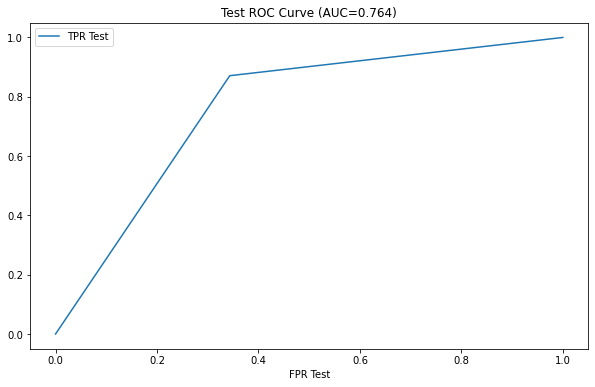

In [27]:
# Plot test set ROC curve
roc_df_test.plot(figsize = (10,6), x="FPR Test", y="TPR Test", title=f"Test ROC Curve (AUC={auc_test})")

<AxesSubplot:title={'center':'Validation ROC Curve (AUC=0.775)'}, xlabel='FPR Val'>

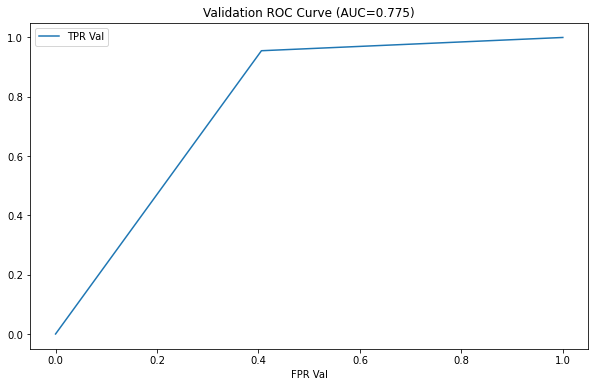

In [28]:
# Plot val set ROC curve
roc_df_val.plot(figsize=(10,6), x="FPR Val", y="TPR Val", title=f"Validation ROC Curve (AUC={auc_val})")